<a href="https://colab.research.google.com/github/gfm-mit/dsst/blob/main/etl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Things to try first
- group by box, patient
- transformer vs cnn vs lstm vs linear
- CLR test accuracy after upramp, and accuracy after downramp
- add CNN before linear model, to mix times _and_ mix channels to get 12

####Things to try later
- group by symbol, patient
  - add box as new channel
- contrastive learning by task, patient
  - w/ and w/o symbol
- next step pretraining
- explicit spatial attention?
- fourier transform the coordinates?

#### Done
- wobble not captured because of odd convolution windows!

In [ ]:
#@title imports (RUN ME FIRST!)
import numpy as np
import pandas as pd
import torch
import shutil
from pathlib import Path
import re
import matplotlib.pyplot as plt
import scipy
from tqdm.notebook import tqdm
try:
  import einops
except ModuleNotFoundError:
  !pip install einops
  import einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.4 MB/s eta 0:00:00


## dynamics

In [ ]:
!unzip DIGITS.zip

In [ ]:
def convolve_and_pool_norm2(x, k, w, k2=[.5, .5]):
  nda_k = np.array(k)[:, np.newaxis]
  conv = scipy.signal.convolve2d(x, nda_k, 'same', fillvalue=np.nan)
  norm2 = np.sum(conv**2, axis=-1)
  avg = np.roll(np.convolve(norm2, k2, 'same'), -1)
  return avg / w
def nanpad_convolve(x, k, w):
  nda_k = np.array(k)[:, np.newaxis]
  conv = scipy.signal.convolve2d(x, nda_k, 'same', fillvalue=np.nan)
  return conv / w
def curvature(dynamics):
  a_cross_v = np.cross(dynamics['a_bar'], dynamics['v_bar'])
  v_bar3 = np.linalg.norm(dynamics['v_bar'], axis=-1) ** 3
  with np.errstate(divide='ignore', invalid='ignore'):
    curvature = a_cross_v / v_bar3
  curvature[v_bar3 == 0] = 0
  with np.errstate(divide='ignore', invalid='ignore'):
    log_curvature = np.sign(curvature) * (1+np.log10(np.abs(curvature)))
  curvature[np.abs(curvature) > 1] = log_curvature[np.abs(curvature) > 1]
  return curvature
def dynamics(stroke):
  retval = dict(
      v_bar=nanpad_convolve(stroke, [1, 0, -1], 2),
      v_mag2=convolve_and_pool_norm2(stroke, [1, -1], 1),
      a_bar=nanpad_convolve(stroke, [1, -2, 1], 2),
      # a has an odd kernel, no need to average magnitudes
      dv_mag2=convolve_and_pool_norm2(stroke, [1, -1], 1, [.5, -.5]),
      j_bar=nanpad_convolve(stroke, [1, -2, 0, 2, -1], 12),
      j_mag2=convolve_and_pool_norm2(stroke, [1, -3, 3, -1], 72),
  )
  retval['cw'] = curvature(retval)
  retval['a_mag2'] = np.sum(retval['a_bar']**2, axis=-1)
  if stroke.shape[0] < 3:
    for k in retval.keys():
      shape = retval[k].shape
      shape = [stroke.shape[0]] if len(shape) == 1 else [stroke.shape[0], shape[1]]
      retval[k] = np.full(shape, np.nan)
  return retval

# test out after compiling
base = np.array([[
    1, 3, 4, 6, 7, 9, 10
], [
    1, 2, 1, 2, 1, 2, 1
]]).astype(float).transpose()
base = np.array([[
    1, 3
], [
    1, 2
]]).astype(float).transpose()
d = dynamics(base)
#plt.plot(base[:, 0], base[:, 1])
#plt.plot(base[:, 0], d['cw'])
d

{'v_bar': array([[nan, nan],
        [nan, nan]]),
 'v_mag2': array([nan, nan]),
 'a_bar': array([[nan, nan],
        [nan, nan]]),
 'dv_mag2': array([nan, nan]),
 'j_bar': array([[nan, nan],
        [nan, nan]]),
 'j_mag2': array([nan, nan]),
 'cw': array([nan, nan]),
 'a_mag2': array([nan, nan])}

dict_keys(['v_bar', 'v_mag2', 'a_bar', 'dv_mag2', 'j_bar', 'j_mag2', 'cw', 'a_mag2'])

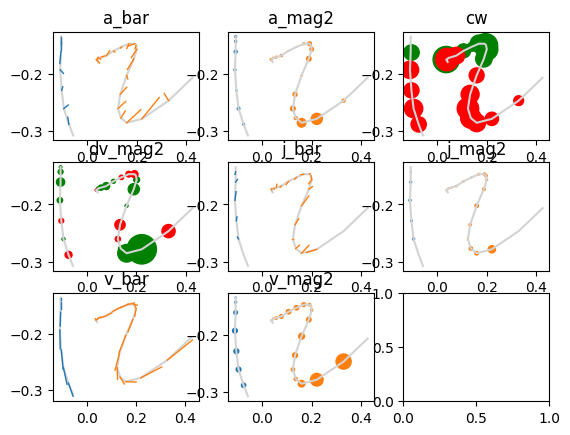

In [ ]:
q = pd.read_csv('/content/DIGITS/CIN1504015974-2016-05-04-18-42-26V6.6.csv')
f = np.random.choice(list(Path('DIGITS').glob('*.csv')), 1)[0]
q = pd.read_csv(f)
q = q.query('task == "baseline" and symbol == 12 and iteration == 0')
fig, axs = plt.subplots(3, 3)
axs = axs.flatten()
for e, (t_min, g) in enumerate(q.groupby("t_min")["x y".split()]):
  d = dynamics(g)
  for ax, c in zip(axs, sorted(d.keys())):
    ax.plot(g.x, g.y, color="lightgray")
    v = d[c]
    if c == "cw":
      s = np.abs(v) * 1e2
      ax.scatter(g.x[v > 0], g.y[v > 0], s=s[v > 0], color="green")
      ax.scatter(g.x[v < 0], g.y[v < 0], s=s[v < 0], color="red")
    elif c == "dv_mag2":
      s = np.abs(v) * 1e5
      ax.scatter(g.x[v > 0], g.y[v > 0], s=s[v > 0], color="green")
      ax.scatter(g.x[v < 0], g.y[v < 0], s=s[v < 0], color="red")
    elif "_bar" in c:
      xy = g["x y".split()].values
      for p0, dp in zip(xy, v):
        s = 1
        if c == "a_bar":
          s *= 3
        if c == "j_bar":
          s *= 10
        stack = np.stack([p0, p0 + dp * s]).transpose()
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][e]
        ax.plot(stack[0], stack[1], color=color, linewidth=1, zorder=10)
    else:
      s = v * 1e4
      if c == "a_mag2":
        s *= 9
      if c == "j_mag2":
        s *= 100
      ax.scatter(g.x, g.y, s=s)
    ax.set_title(c)
d.keys()

## reformat the digits into the TS

In [ ]:
#!unzip DIGITS.zip
def get_pause(raw):
  strokes = raw.groupby("t_min").t.max().sort_index()
  pause = strokes.index.values[1:] - strokes.values[:-1]
  pause = pd.Series(pause, index=strokes.index.values[1:])
  pause.loc[0] = 0
  pause = pause.sort_index()
  return pause
def convert():
  try:
    shutil.rmtree('TS')
  except FileNotFoundError:
    pass
  for f in tqdm(list(Path('DIGITS').glob('*.csv'))):
    raw = pd.read_csv(f)
    pause = get_pause(raw)
    pkey = f.name.replace('.csv', '')
    for (symbol, task, iteration), g in raw.groupby('symbol task iteration'.split()):
      accum = []
      if True:
        for t_min, g2 in g.groupby('t_min'):
          d = dynamics(g2["x y".split()])
          try:
            munged = pd.DataFrame({
                k: d[k]
                for k in "v_mag2 a_mag2 dv_mag2 cw j_mag2".split()
                if k in d
            })
          except ValueError:
            assert False, (g2, d)
          munged["pause"] = pause.loc[t_min]
          munged.v_mag2 *= 1.5e4
          munged.a_mag2 *= 3e5
          munged.dv_mag2 *= 4e4
          munged.j_mag2 *= 5e6
          munged.pause = np.log10(1+munged.pause) - 4.1
      accum += [munged]
      munged = pd.concat(accum)
      f_out = Path('TS') / pkey / str(symbol) / task / "{}.npy".format(iteration)
      f_out.parent.mkdir(exist_ok=True, parents=True)
      np.save(f_out, munged.values)
convert()

  0%|          | 0/257 [00:00<?, ?it/s]

In [ ]:
!zip TS.zip TS/*/*/*/*.npy

## metadata

In [ ]:
#@title munge metadata_coarse.csv (shouldn't need to run)
# these errored out in generation, and I didn't bother to write a new
if True:
  hacks = """
  CIN1495929890-2017-01-11-10-02-24V6.5
  CIN1945553658-2018-08-08-10-40-51V6.8
  CIN0363712923-2020-03-09-10-54-43V6.9
  """.split()
  hacks = [re.sub('^CSV/', 'CSV/', x) for x in hacks]
  metadata = pd.read_csv('metadata_coarse.csv')
  metadata.csv = metadata.csv.str.replace('^CSV/', '', regex=True)
  metadata.csv = metadata.csv.str.replace('[.]csv$', '', regex=True)
  metadata = metadata.rename(columns=dict(csv='pkey'))
  metadata = metadata.set_index('pkey')
  metadata = metadata.drop(columns=["Unnamed: 0"])
  metadata = metadata.drop(index=hacks)


  top4 = ["Healthy Control", "Alzheimer's"]#, "Parkinsonism", "MCI"]
  metadata = metadata[metadata.coarse.isin(top4)]
  metadata.coarse = pd.Categorical(metadata.coarse, top4)
  #metadata['sick'] = 1 * (metadata.coarse == "Alzheimer's")

  decile = pd.util.hash_array(metadata.index.values) % 10
  metadata['split'] = np.select(
      [decile <= 6, decile <= 7, decile <= 8],
      ["train", "val", "test"],
      "holdout")
  metadata.split = metadata.split.astype('category')
  metadata = metadata["coarse split".split()]
  metadata = metadata[metadata.split != "holdout"]
  metadata.to_csv('metadata_4way.csv')

In [ ]:
metadata = pd.read_csv('metadata_4way.csv').set_index('split').sort_values(by=["split", "coarse"])
metadata.coarse = pd.Categorical(metadata.coarse, top4)
metadata

,pkey,coarse
split,,
test,CIN1055442650-2014-11-14-14-38-28V5.2,Alzheimer's
test,CIN1086147349-2016-09-13-10-57-52V6.5,Alzheimer's
test,CIN1554730950-2016-06-01-11-29-00V6.5,Alzheimer's
test,CIN0997844437-2019-01-11-11-37-53V6.8,Alzheimer's
test,CIN0874223574-2016-12-16-14-15-36V6.5,Alzheimer's
...,...,...
val,CIN0477484821-2015-03-20-10-37-31V5.3,Healthy Control
val,CIN1964824098-2015-11-05-12-31-00V6.0,Healthy Control
val,CIN1163598278-2020-02-24-11-07-12V6.9,Healthy Control


## now load the npy files

In [ ]:
!rm -rf TS/
!unzip TS.zip | tail -n 10

  inflating: TS/CIN2142576210-2016-03-30-11-37-07V6.5/2/timed/6.npy  
  inflating: TS/CIN2142576210-2016-03-30-11-37-07V6.5/2/translated/0.npy  
  inflating: TS/CIN2142576210-2016-03-30-11-37-07V6.5/2/translated and timed/0.npy  
  inflating: TS/CIN2142576210-2016-03-30-11-37-07V6.5/2/translated and timed/1.npy  
  inflating: TS/CIN2142576210-2016-03-30-11-37-07V6.5/2/translated and timed/2.npy  
  inflating: TS/CIN2142576210-2016-03-30-11-37-07V6.5/2/translated and timed/3.npy  
  inflating: TS/CIN2142576210-2016-03-30-11-37-07V6.5/2/translated and timed/4.npy  
  inflating: TS/CIN2142576210-2016-03-30-11-37-07V6.5/2/translated and timed/5.npy  
  inflating: TS/CIN2142576210-2016-03-30-11-37-07V6.5/2/translated and timed/6.npy  
  inflating: TS/CIN2142576210-2016-03-30-11-37-07V6.5/2/translated and timed/7.npy  


In [ ]:
#@title SeqDataset

class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, metadata, trunc=512):
        uniq_splits = np.unique(metadata.index)
        assert uniq_splits.shape[0] == 1, uniq_splits
        self.md = metadata.copy()
        self.md.coarse = self.md.coarse.cat.codes
        self.trunc = trunc
        rows = []
        for _, (pkey, coarse) in self.md.iterrows():
          for npy in (Path('TS/') / pkey).glob('**/*.npy'):
            rows += [[*npy.parts, npy, coarse]]
        assert len(rows)
        self.files = pd.DataFrame(rows)
        self.files.columns = "folder pkey symbol task iteration path coarse".split()
        self.files = self.files.drop(columns="folder iteration".split())
        self.files = self.files.set_index("symbol pkey task".split())

    def __getitem__(self, index):
        path, coarse = self.files.iloc[index]
        nda = np.load(str(path)) # t, c
        x = torch.Tensor(nda[:self.trunc, :])
        y = torch.LongTensor([coarse])
        return x, y

    def __len__(self):
        return self.files.shape[0]

def collate_fn_padd(batch):
    features, targets = zip(*batch)

    l = np.max([nda.shape[0] for nda in features])

    # TODO: silly to go to numpy and back to tensors
    def pad_to(seq, l):
      dl = l - seq.shape[0]
      return np.pad(seq, [(0, dl), (0, 0)])
    features = np.stack([
        pad_to(x, l)
        for x in features
    ])
    features = np.nan_to_num(features, 0)
    features = einops.rearrange(features, 'b l c -> b c l')
    return torch.Tensor(features), torch.Tensor(targets).long()

train_data = SeqDataset(metadata.loc["train"])
val_data = SeqDataset(metadata.loc["val"])
test_data = SeqDataset(metadata.loc["test"])
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, collate_fn=collate_fn_padd)
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=1000, shuffle=True, collate_fn=collate_fn_padd)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=1000, shuffle=True, collate_fn=collate_fn_padd)

z = next(iter(train_loader))
z[0].shape, z[1].shape, z[0].sum(), z[1].sum()

##q = ModelWrapper(512)
#q.reset()
#train(0, q, FakeOptimizer(q.parameters()), 'cuda')
##tgt, pred, _ = test(q)
#qq = pd.DataFrame(dict(target=tgt, predicted=pred))
#qq = qq.target.groupby([qq.target, qq.predicted]).count().unstack()
#qq.index = train_loader.dataset.translate(qq.index)
#qq.columns = train_loader.dataset.translate(qq.columns)
#np.diag(qq).sum() / qq.sum().sum()

(torch.Size([64, 6, 177]), torch.Size([64]), tensor(59674.0234), tensor(37))

## Model Library

In [ ]:
#@title def get_jank_model(Linear):
from einops.layers.torch import Rearrange
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

class NegCat(torch.nn.Module):
  def forward(self, input):
    return torch.cat([input, -input], axis=1)

def get_jank_model(hidden_width=512, device='cuda', classes=2):
  model = torch.nn.Sequential(
      NegCat(),
      torch.nn.AdaptiveMaxPool1d(1),
      Rearrange('b c 1 -> b c'),
      torch.nn.Linear(12, hidden_width),
      torch.nn.PReLU(num_parameters=1),
      torch.nn.GroupNorm(1, hidden_width, eps=1e-08, affine=True),
    torch.nn.Linear(hidden_width, classes),
      torch.nn.Softmax(dim=-1),
  )
  model = model.to(device)
  base_params = dict(
    momentum=0.95, # or maybe .95
    beta2=0.995,
    weight_decay=1e-5, # or maybe 0
    pct_start=.6,

    max_epochs=10,
    min_epochs=5,

    learning_rate=7e-3, # from lr_finder
    hidden_width=8,
  )
  return model, base_params
q, _ = get_jank_model(hidden_width=8, device='cuda')
r = q(next(iter(train_loader))[0].to('cuda'))
r.shape

torch.Size([64, 2])

In [ ]:
#@title def get_jank_model(LSTM):
from einops.layers.torch import Rearrange
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

class Backwards(torch.nn.Module):
  def forward(self, input):
    return torch.flip(input, dims=(2,))

class RnnCleaner(torch.nn.Module):
  def forward(self, input):
    return input[0][:, -1, :]

def get_jank_model(hidden_width=512, device='cuda'):
  input_width = 8
  model = torch.nn.Sequential(
      torch.nn.Conv1d(
          in_channels=6,
          out_channels=input_width,
          kernel_size=1,
          stride=1,
          padding=0,
          bias=False,
      ),
      torch.nn.PReLU(num_parameters=1),
      torch.nn.GroupNorm(1, input_width, eps=1e-08, affine=True),
      Rearrange('b c l -> b l c'),
      Backwards(),
      torch.nn.LSTM(
        input_size=input_width,
        hidden_size=hidden_width,
        batch_first=True,
      ),
      RnnCleaner(),
      torch.nn.Linear(hidden_width, 4),
      torch.nn.Sigmoid(),
      #Rearrange('b 1 -> b'),
  )
  model = model.to(device)
  base_params = dict(
    momentum=0.95, # or maybe .95
    beta2=0.995,
    weight_decay=1e-5, # or maybe 0
    pct_start=.6,

    max_epochs=10,
    min_epochs=5,

    learning_rate=5e-3, # from lr_finder
    hidden_width=64,
  )
  return model, base_params
q, _ = get_jank_model(hidden_width=128, device='cuda')
r = q(next(iter(train_loader))[0].to('cuda'))
r.shape

torch.Size([64, 4])

In [ ]:
#@title def get_jank_model(TRANSFORMER):
from einops.layers.torch import Rearrange
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

class Backwards(torch.nn.Module):
  def forward(self, input):
    return torch.flip(input, dims=(1,))

class RnnCleaner(torch.nn.Module):
  def forward(self, input):
    return input[0][:, 0, :]

def get_jank_model(hidden_width=512, device='cuda'):
  model = torch.nn.Sequential(
      torch.nn.Conv1d(
          in_channels=6,
          out_channels=hidden_width,
          kernel_size=1,
          stride=1,
          padding=0,
          bias=False,
      ),
      torch.nn.PReLU(num_parameters=1),
      torch.nn.GroupNorm(1, hidden_width, eps=1e-08, affine=True),
      Rearrange('b c l -> b l c'),
      torch.nn.TransformerEncoderLayer(
        nhead=8,
        d_model=hidden_width,
        dim_feedforward=hidden_width,
        batch_first=True,
      ),
      Rearrange('b l c -> b c l'),
      torch.nn.Conv1d(
          in_channels=hidden_width,
          out_channels=hidden_width,
          kernel_size=1,
          stride=1,
          padding=0,
          bias=False,
      ),
      torch.nn.PReLU(num_parameters=1),
      torch.nn.GroupNorm(1, hidden_width, eps=1e-08, affine=True),
      torch.nn.AdaptiveMaxPool1d(1),
      Rearrange('b c 1 -> b c'),
      torch.nn.Linear(hidden_width, 4),
      #Rearrange('b 1 -> b'),
      torch.nn.Sigmoid(),
  )
  model = model.to(device)
  base_params = dict(
    momentum=0.95, # or maybe .95
    beta2=0.995,
    weight_decay=1e-5, # or maybe 0
    pct_start=.6,

    max_epochs=10,
    min_epochs=5,

    learning_rate=2e-4, # from lr_finder
    hidden_width=64,
  )
  return model, base_params
q, _ = get_jank_model(hidden_width=128, device='cuda')
r = q(next(iter(train_loader))[0].to('cuda'))
r.shape

torch.Size([64, 294, 128])

In [1]:
#@title def get_jank_model(CNN):
from einops.layers.torch import Rearrange
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

def get_jank_model(hidden_width=512, device='cuda'):
  model = torch.nn.Sequential(
      torch.nn.Conv1d(
          in_channels=6,
          out_channels=hidden_width,
          kernel_size=5,
          stride=1,
          padding=0,
          bias=False,
      ),
      torch.nn.PReLU(num_parameters=1),
      torch.nn.GroupNorm(1, hidden_width, eps=1e-08, affine=True),

      torch.nn.AdaptiveMaxPool1d(100),
      Rearrange('b c (h w) -> b c h w', h=10, w=10),

      torch.nn.Conv2d(
          groups=hidden_width,
          in_channels=hidden_width,
          out_channels=hidden_width,
          kernel_size=(11, 11),
          stride=1,
          padding=(5, 5),
          bias=False,
      ),

      torch.nn.PReLU(num_parameters=1),
      torch.nn.GroupNorm(1, hidden_width, eps=1e-08, affine=True),

      torch.nn.Conv2d(
          in_channels=hidden_width,
          out_channels=hidden_width,
          kernel_size=(11, 1),
          stride=1,
          padding=(5,0),
          bias=False,
      ),
      torch.nn.PReLU(num_parameters=1),
      torch.nn.GroupNorm(1, hidden_width, eps=1e-08, affine=True),

      torch.nn.Conv2d(
          in_channels=hidden_width,
          out_channels=hidden_width,
          kernel_size=(1, 11),
          stride=1,
          padding=(0,5),
          bias=False,
      ),
      torch.nn.PReLU(num_parameters=1),
      torch.nn.GroupNorm(1, hidden_width, eps=1e-08, affine=True),

      Rearrange('b c h w -> b c (h w)', h=10, w=10),

      #torch.nn.Conv1d(
      #    in_channels=hidden_width,
      #    out_channels=hidden_width,
      #    kernel_size=21,
      #    stride=10,
      #    padding=10,
      #    bias=False,
      #),
      #torch.nn.PReLU(num_parameters=1),
      #torch.nn.GroupNorm(1, hidden_width, eps=1e-08, affine=True),

      torch.nn.AdaptiveMaxPool1d(1),
      Rearrange('b c 1 -> b c'),
      torch.nn.Linear(hidden_width, 1),
      torch.nn.Sigmoid(),
      Rearrange('b 1 -> b'),
  )
  model = model.to(device)
  return model
q = get_jank_model(hidden_width=128, device='cuda')
r = q(next(iter(train_loader))[0].to('cuda'))
r.shape

ModuleNotFoundError: ignored

## training loop

(125,)


<ipython-input-16-601bd5106c7a>:34: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.axvline(x=argmin, color="gray")


0.009437878277775372

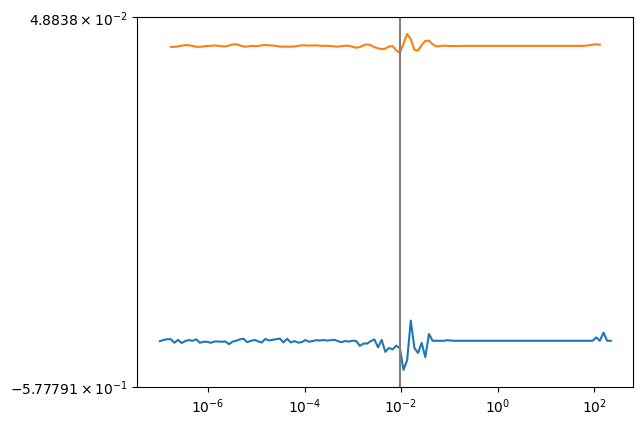

In [ ]:
def lr_finder(model, schedule):
  DEVICE = next(model.parameters()).device
  model.train()
  losses = {}
  for e, (data, target) in enumerate(train_loader):
    lr = schedule[e]
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=lr,
                                  betas=[.9, .999],
                                  weight_decay=1e-2)
    optimizer.zero_grad()
    output = model(data.to(DEVICE))
    weights = balance_class_weights(target)
    loss = torch.nn.functional.nll_loss(
        output, target.to(DEVICE), weight=weights.to(DEVICE))
    loss.backward()
    losses[lr] = loss.item()
    optimizer.step()
  return pd.Series(losses)
def plot_lr_results(model):
  losses = lr_finder(model, np.geomspace(1e-7, 1e8, 200))
  k = np.convolve([1, 0, -1], [1, 4, 6, 4, 1], 'full')
  k = k / np.abs(k).sum()
  derivative = np.convolve(losses, k, 'valid')
  k = len(k) // 2
  derivative = np.pad(derivative, [k, k], constant_values=np.nan)
  derivative = pd.Series(derivative, index=losses.index)
  plt.plot(losses)
  plt.plot(derivative)
  plt.xscale('log')
  plt.yscale('symlog')
  argmin = derivative.argmin()
  argmin = derivative.index[argmin]
  plt.axvline(x=argmin, color="gray")
  print(derivative.shape)
  return argmin

q, _ = get_jank_model(64, device='cuda')
qq = plot_lr_results(q)
qq

In [ ]:
#@title def optimize(epoch, model, optimizer), metrics(model):
#%%prun -s cumtime
from pathlib import Path

Path('./results/').mkdir(parents=True, exist_ok=True)

def balance_class_weights(target):
    w = torch.nn.functional.one_hot(target).float().mean(axis=0)
    w = 1 / w
    w = torch.clip(w, 0, 10)
    w = w / w.sum()
    return w

def optimize(epoch, model, optimizer):
  DEVICE = next(model.parameters()).device
  model.train()
  for data, target in train_loader:
    optimizer.zero_grad()
    output = model(data.to(DEVICE))
    class_weights = balance_class_weights(target)
    loss = torch.nn.functional.nll_loss(
        output, target.to(DEVICE), weight=class_weights.to(DEVICE))
    loss.backward()
    optimizer.step()
  torch.save(model.state_dict(), './results/model.pth')
  print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
  return loss.item()

def metrics(model):
  DEVICE = next(model.parameters()).device
  results = []
  model.eval()
  with torch.no_grad():
    for data, target in val_loader:
      output = model(data.to(DEVICE)).to('cpu')
      results += [(
          output.detach().numpy(),
          target.detach().to('cpu').numpy(),
      )]
  logits, targets = zip(*results)
  logits = np.concatenate(logits)
  predictions = np.argmax(logits, axis=1)
  targets = np.concatenate(targets)
  return None, (predictions == targets).mean()
  #return logits, targets

class FakeOptimizer():
  def __init__(self, model):
    super(FakeOptimizer, self).__init__()
    layer_lookup = {
        k: str(v)
        for k, v in model.named_modules()
        if k
    }
    parameters = [
        (list(map(str, v.shape)), *k.split(".", maxsplit=1))
        for k, v in model.named_parameters()
    ]
    for s, l, p in parameters:
      print("{:>10}: {:10}<-{}".format(
          ", ".join(s[::-1]), p, layer_lookup.get(l, l)
      ))
  def zero_grad(self):
    pass
  def step(self):
    pass
  def state_dict(self):
    return {}
q, _ = get_jank_model(128, device='cuda')
optimize(0, q, FakeOptimizer(q))
loss, accuracy = metrics(q)
loss, accuracy

   12, 128: weight    <-Linear(in_features=12, out_features=128, bias=True)
       128: bias      <-Linear(in_features=12, out_features=128, bias=True)
         1: weight    <-PReLU(num_parameters=1)
       128: weight    <-GroupNorm(1, 128, eps=1e-08, affine=True)
       128: bias      <-GroupNorm(1, 128, eps=1e-08, affine=True)
    128, 2: weight    <-Linear(in_features=128, out_features=2, bias=True)
         2: bias      <-Linear(in_features=128, out_features=2, bias=True)
Train Epoch: 0 	Loss: -0.515376


(None, 0.22209302325581395)

In [ ]:
#@title def one_hyperparam(), many_hyperparams():
Path('./results').mkdir(parents=True, exist_ok=True)
def one_hyperparam(model, optimizer, scheduler, min_epochs, max_epochs):
  max_loss = 3
  resdict = dict(loss=np.nan, accuracy=np.nan)
  for x in range(max_epochs):
    #train_data = ContrastiveDataset('./TRAIN/', seed=str(np.random.randint(10)))
    #val_data = ContrastiveDataset('./TEST/', seed=str(np.random.randint(10)))
    # TODO: reshuffle data after each epoch, of course
    #train_loader = torch.utils.data.DataLoader(
    #    train_data, batch_size=batch_size_train, shuffle=False, collate_fn=collate_fn_padd)
    #val_loader = torch.utils.data.DataLoader(
    #    val_data, batch_size=batch_size_test, shuffle=False, collate_fn=collate_fn_padd)

    next_loss = optimize(x, model, optimizer)
    scheduler.step()
    if next_loss > max_loss and x > min_epochs:
      break
    if np.isnan(next_loss):
      break
    max_loss = next_loss
    torch.cuda.empty_cache()
    resdict = dict(zip("loss accuracy".split(), metrics(model)))

    torch.cuda.empty_cache()
  return resdict, model

def many_hyperparams(params, model_factory_fn, pretrained=False):
  model, _ = model_factory_fn(**{
      k: params[k]
      for k in "hidden_width".split()
      })

  if pretrained:
    network_state_dict = torch.load('sequence_pretrain.pth')
    model.load_state_dict(network_state_dict, strict=False)
  else:
    for layer in model.children():
      if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

  optimizer = torch.optim.AdamW(model.parameters(),
                                lr=params["learning_rate"],
                                betas=[
                                    params["momentum"],
                                    params["beta2"],
                                ],
                                weight_decay=params["weight_decay"])
  scheduler = torch.optim.lr_scheduler.OneCycleLR(
      optimizer,
      max_lr=params["learning_rate"],
      steps_per_epoch=1,
      pct_start=params["pct_start"],
      epochs=params["max_epochs"] // 1)

  torch.cuda.empty_cache()
  return one_hyperparam(model, optimizer, scheduler,
                        min_epochs=params["min_epochs"],
                        max_epochs=params["max_epochs"])

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
if True:
  # good enough, gets to 90
  base_params = dict(
    momentum=0.95, # or maybe .95
    beta2=0.995,
    weight_decay=1e-5, # or maybe 0
    pct_start=.6,

    max_epochs=10,
    min_epochs=5,

    learning_rate=1.5e-1, # from lr_finder
    hidden_width=128,
  )
_, base_params = get_jank_model()

results = []
spaces = pd.DataFrame(dict(
    #learning_rate=np.random.permutation(np.geomspace(1e-6, 1e-2, 5)),
    hidden_width=np.random.permutation([
        8,
        32,
        128,
        512,
    ]),
    #pct_start=[.3, .6],
    #weight_decay=[.01],
    #pct_start=np.random.permutation(np.linspace(.3, .7, 5))
))
spaces
for i in tqdm(spaces.index):
  params = dict(**base_params)
  for k in spaces.columns:
    params[k] = spaces.loc[i, k]
  retval, model = many_hyperparams(params, model_factory_fn=get_jank_model)
  results += [dict(**params, **retval)]
q = pd.DataFrame(results)
q

  0%|          | 0/4 [00:00<?, ?it/s]

Train Epoch: 0 	Loss: -0.490089
Train Epoch: 1 	Loss: -0.550069
Train Epoch: 2 	Loss: -0.549165
Train Epoch: 3 	Loss: -0.357628
Train Epoch: 4 	Loss: -0.532099
Train Epoch: 5 	Loss: -0.487730
Train Epoch: 6 	Loss: -0.500000
Train Epoch: 7 	Loss: -0.500000
Train Epoch: 8 	Loss: -0.500000
Train Epoch: 9 	Loss: -0.500000
Train Epoch: 0 	Loss: -0.497977
Train Epoch: 1 	Loss: -0.600226
Train Epoch: 2 	Loss: -0.535806
Train Epoch: 3 	Loss: -0.550355
Train Epoch: 4 	Loss: -0.621755
Train Epoch: 5 	Loss: -0.652896
Train Epoch: 6 	Loss: -0.512054
Train Epoch: 0 	Loss: -0.498039
Train Epoch: 1 	Loss: -0.484579
Train Epoch: 2 	Loss: -0.616175
Train Epoch: 3 	Loss: -0.502922
Train Epoch: 4 	Loss: -0.593365
Train Epoch: 5 	Loss: -0.523126
Train Epoch: 6 	Loss: -0.514065
Train Epoch: 0 	Loss: -0.475867
Train Epoch: 1 	Loss: -0.596866
Train Epoch: 2 	Loss: -0.643983
Train Epoch: 3 	Loss: -0.529293
Train Epoch: 4 	Loss: -0.584962
Train Epoch: 5 	Loss: -0.568543
Train Epoch: 6 	Loss: -0.603947
Train Ep

,momentum,beta2,weight_decay,pct_start,max_epochs,min_epochs,learning_rate,hidden_width,loss,accuracy
0,0.95,0.995,0.00001,0.6,10,5,0.007,512,None,0.246512
1,0.95,0.995,0.00001,0.6,10,5,0.007,128,None,0.646512
2,0.95,0.995,0.00001,0.6,10,5,0.007,8,None,0.734884
3,0.95,0.995,0.00001,0.6,10,5,0.007,32,None,0.665116


,momentum,beta2,weight_decay,pct_start,max_epochs,min_epochs,learning_rate,hidden_width,loss,accuracy
0,0.95,0.995,0.00001,0.6,10,5,0.005,8,None,0.430851
1,0.95,0.995,0.00001,0.6,10,5,0.005,128,None,0.430851
2,0.95,0.995,0.00001,0.6,10,5,0.005,32,None,0.430851
3,0.95,0.995,0.00001,0.6,10,5,0.005,512,None,0.430851


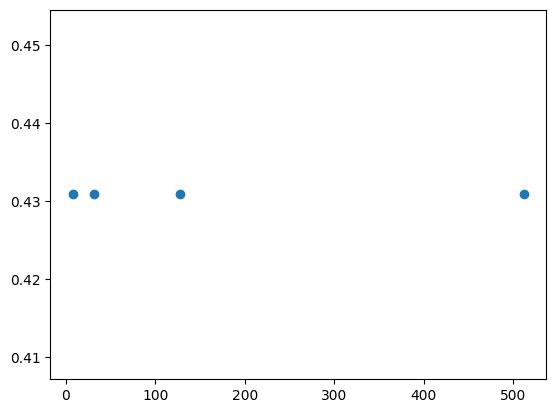

In [ ]:
import matplotlib.pyplot as plt
q = pd.DataFrame(results)
plt.scatter((q.hidden_width), q.accuracy)
q